In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import logging
import os

import matplotlib
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from src.parameters import FIGURE_DIR

# Set background and fontsize
rc_params = {
    'pdf.fonttype': 42, # Make fonts editable in Adobe Illustrator
    'ps.fonttype': 42, # Make fonts editable in Adobe Illustrator
    'axes.labelcolor': '#222222',
    'axes.labelsize': 9,
    'text.color': '#222222',
    'font.sans-serif' : 'Helvetica',
    'text.usetex': False,
    'figure.figsize': (7.2, 4.45),
    'xtick.major.size': 0.00,
    'ytick.major.size': 0.00,
    'axes.labelpad': 0.1,
    }
sns.set(style='white', context='talk', rc=rc_params,
        font_scale=1.0)

# Make analysis reproducible
np.random.seed(0)

# Enable logging
logging.basicConfig(level=logging.INFO)

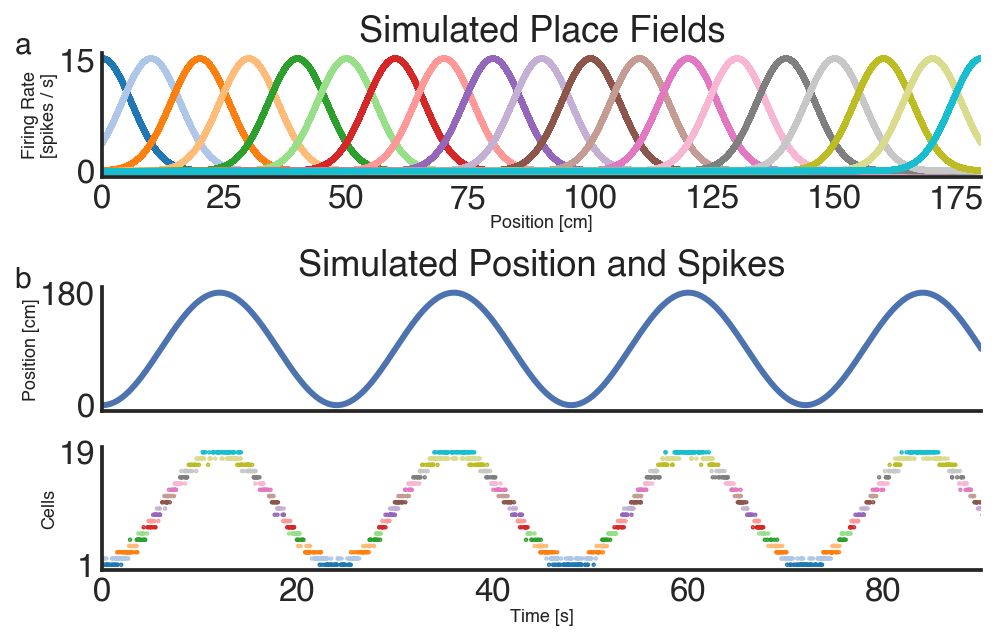

In [3]:
from src.sorted_spikes_simulation import make_simulated_run_data
from src.figure_utilities import TWO_COLUMN, GOLDEN_RATIO

time, linear_distance, sampling_frequency, spikes, place_fields = make_simulated_run_data()
spike_ind, neuron_ind = np.nonzero(spikes)
cmap = plt.get_cmap('tab20')

fig, axes = plt.subplots(3, 1, figsize=(TWO_COLUMN, TWO_COLUMN * GOLDEN_RATIO), constrained_layout=True)
for place_field, color in zip(place_fields.T, cmap.colors):
    axes[0].plot(linear_distance, place_field, linewidth=3, color=color)
axes[0].set_xlabel('Position [cm]')
axes[0].set_ylabel('Firing Rate\n[spikes / s]')
axes[0].set_title('Simulated Place Fields')
axes[0].set_xlim((linear_distance.min(), linear_distance.max()))
axes[0].set_yticks([0, np.round(place_fields.max())])
axes[0].text(-0.10, 1.0, 'a', transform=axes[0].transAxes, 
        size=15, weight='extra bold')

axes[1].plot(time, linear_distance, linewidth=3)
axes[1].set_ylabel('Position [cm]')
axes[1].set_title('Simulated Position and Spikes')
axes[1].set_yticks([0, np.round(linear_distance.max())])
axes[1].set_xticks([])
axes[1].set_xlim((0.0, 90.0))
axes[1].text(-0.10, 1.0, 'b', transform=axes[1].transAxes, 
        size=15, weight='extra bold')

c = [cmap.colors[ind] for ind in neuron_ind]
axes[2].scatter(time[spike_ind], neuron_ind + 1, c=c, s=0.5)
axes[2].set_yticks((1, spikes.shape[1]))
axes[2].set_ylabel('Cells')

axes[2].set_xlabel('Time [s]')
axes[2].set_xlim((0.0, 90.0))

sns.despine()

In [4]:
from replay_trajectory_classification import SortedSpikesClassifier
from src.parameters import (ANIMALS, FIGURE_DIR, PROBABILITY_THRESHOLD,
                            PROCESSED_DATA_DIR, SAMPLING_FREQUENCY,
                            TRANSITION_TO_CATEGORY,
                            discrete_diag,
                            knot_spacing, model, model_kwargs, movement_var,
                            place_bin_size, replay_speed, spike_model_penalty)

continuous_transition_types = (
    [['random_walk_minus_identity', 'inverse_random_walk', 'identity'],  # noqa
     ['uniform',                    'inverse_random_walk', 'uniform'],   # noqa
     ['random_walk_minus_identity', 'inverse_random_walk', 'identity']])  # noqa


classifier = SortedSpikesClassifier(
    place_bin_size=place_bin_size, movement_var=movement_var,
    replay_speed=replay_speed,
    discrete_transition_diag=discrete_diag,
    spike_model_penalty=spike_model_penalty, knot_spacing=knot_spacing,
        continuous_transition_types=continuous_transition_types)
classifier.fit(linear_distance, spikes)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...


SortedSpikesClassifier(continuous_transition_types=[['random_walk_minus_identity',
                                                     'inverse_random_walk',
                                                     'identity'],
                                                    ['uniform',
                                                     'inverse_random_walk',
                                                     'uniform'],
                                                    ['random_walk_minus_identity',
                                                     'inverse_random_walk',
                                                     'identity']],
                       discrete_transition_diag=0.999,
                       discrete_transition_type='strong_diagonal',
                       infer_track_interior=True,
                       initial_conditions_type='uniform_on_track',
                       knot_spacing=5, movement_var=4.0, place_bin_size=2.0,
                       posit

In [5]:
from src.parameters import TRANSITION_TO_CATEGORY, STATE_COLORS

def plot_classification(replay_time, test_spikes, results):
    results = results.assign_coords(
        state=lambda ds: ds.state.to_index()
        .map(TRANSITION_TO_CATEGORY))
    fig, axes = plt.subplots(3, 1, figsize=(10, 6), constrained_layout=True, sharex=True)
    spike_time_ind, neuron_ind = np.nonzero(test_spikes)
    axes[0].scatter(replay_time[spike_time_ind], neuron_ind, color='black', zorder=1,
                    marker='|', s=80, linewidth=3)
    axes[0].set_yticks((0, test_spikes.shape[1]))
    axes[0].set_ylabel('Neuron Index')
    replay_probability = results.acausal_posterior.sum('position')
    for state, prob in replay_probability.groupby('state'):
        axes[1].plot(prob.time, prob.values, linewidth=4, label=state, color=STATE_COLORS[state])
    axes[1].set_ylabel('Probability')
    axes[1].set_yticks([0, 1])
    axes[1].set_ylim((-0.01, 1.05))

    results.acausal_posterior.sum('state').plot(
        x='time', y='position', robust=True, vmin=0.0, ax=axes[2])
    axes[2].set_ylabel('Position [cm]')
    plt.xlim((replay_time.min(), replay_time.max()))
    axes[-1].set_xlabel('Time [ms]')
    sns.despine()

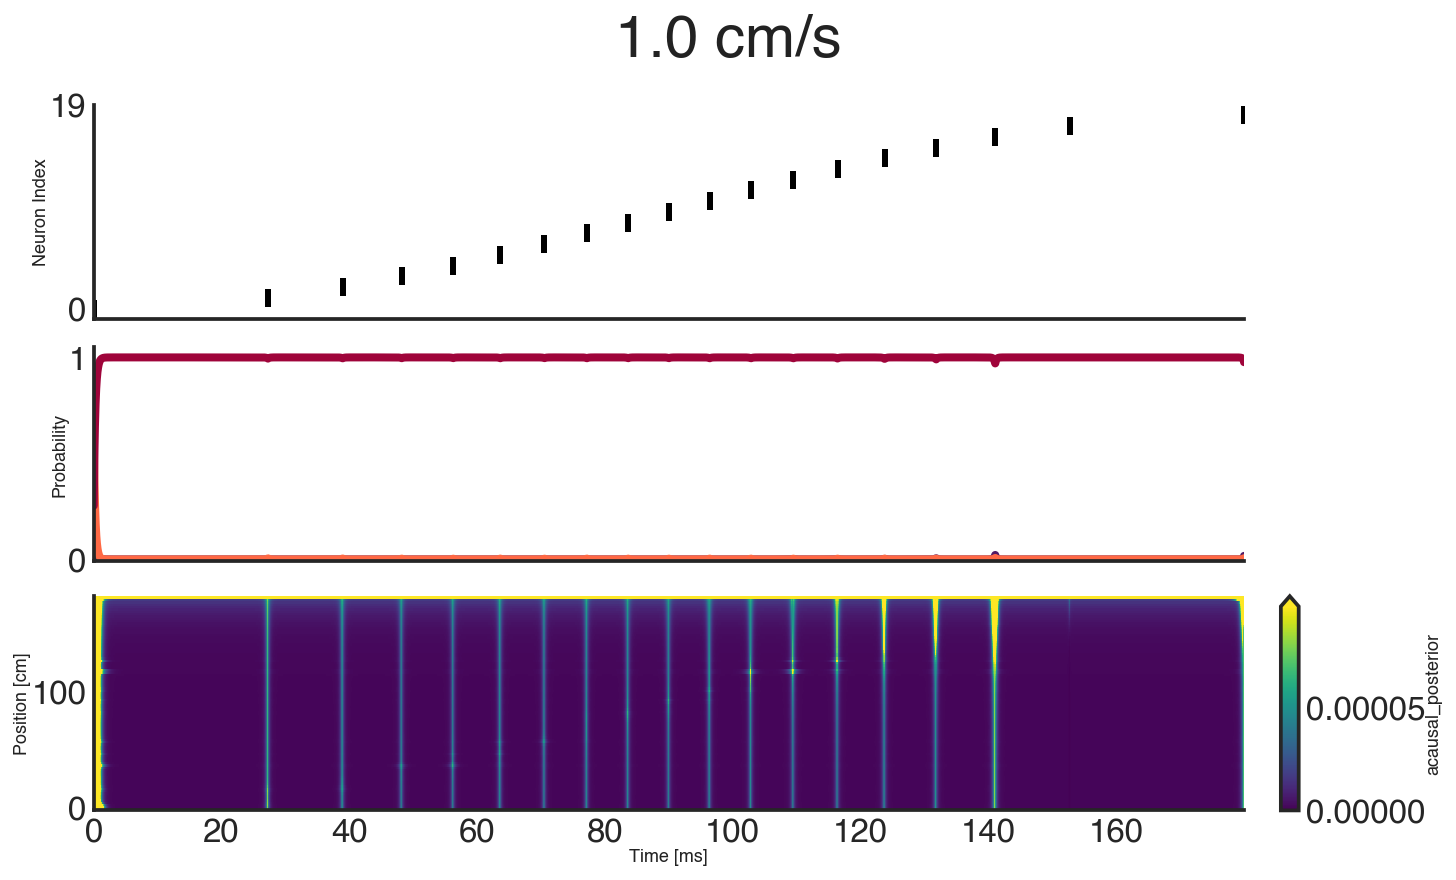

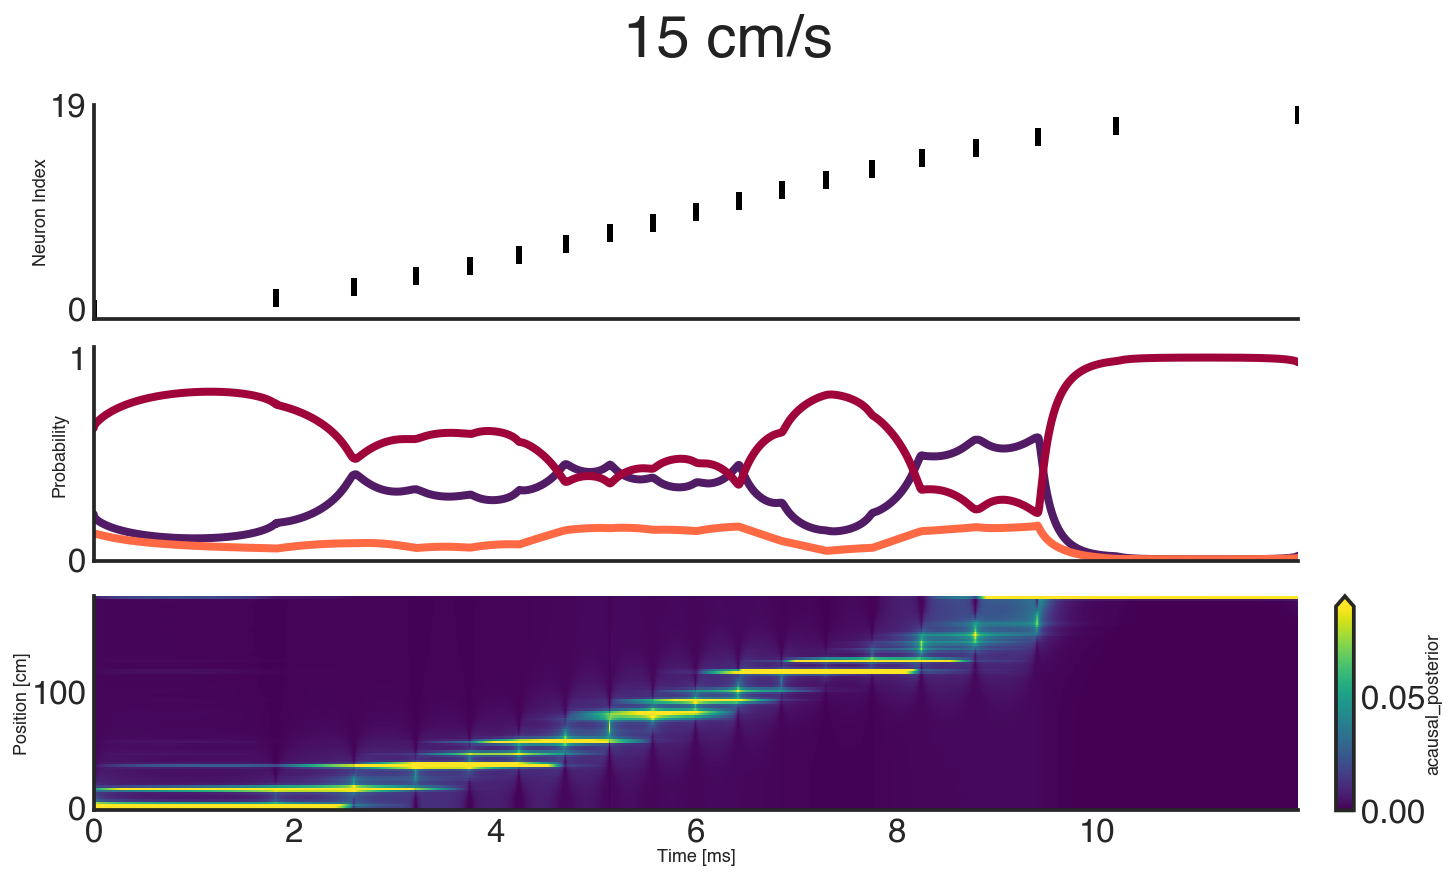

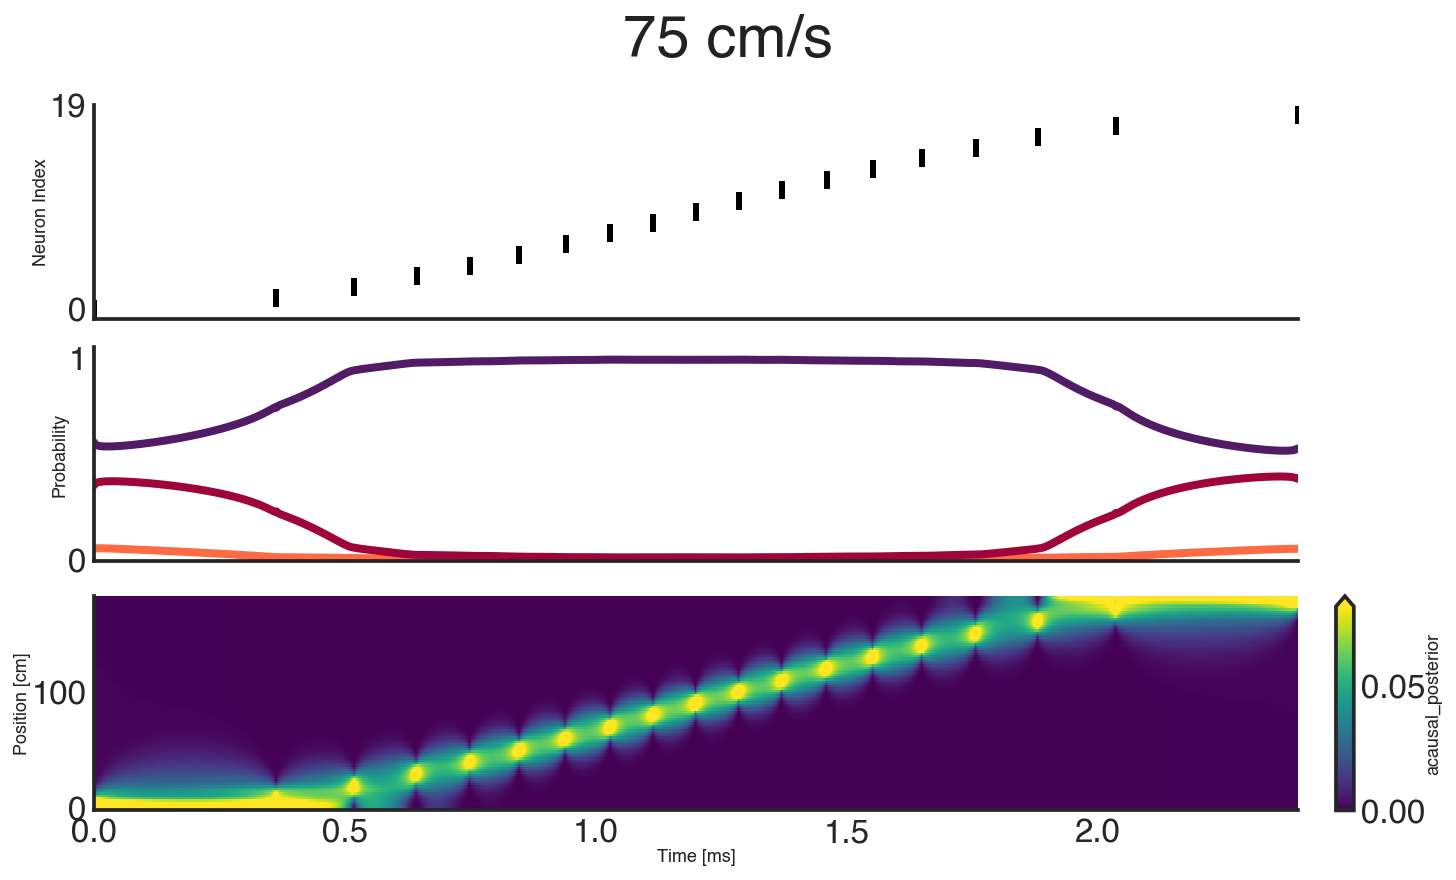

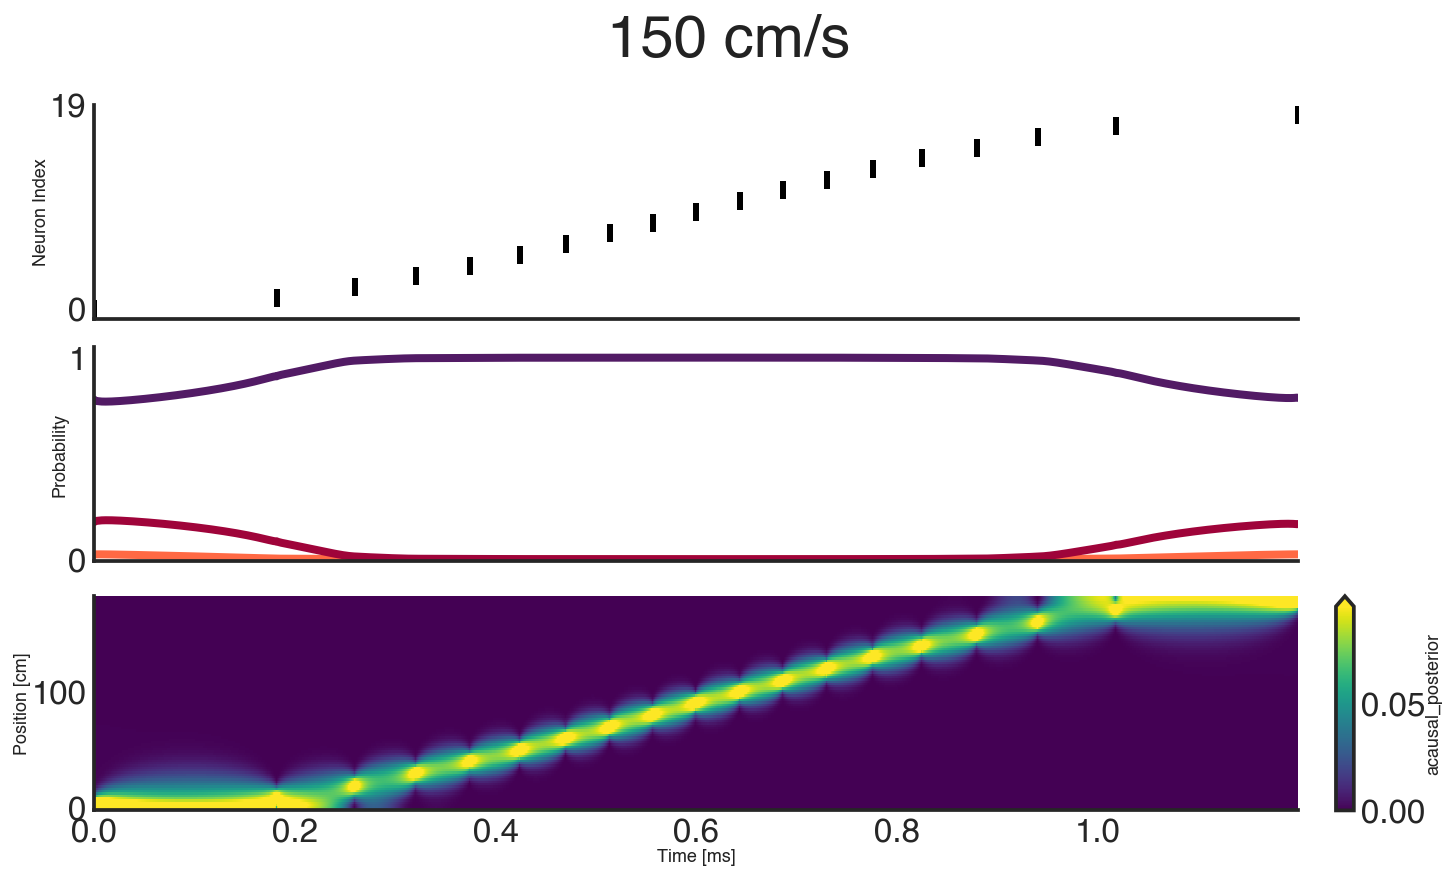

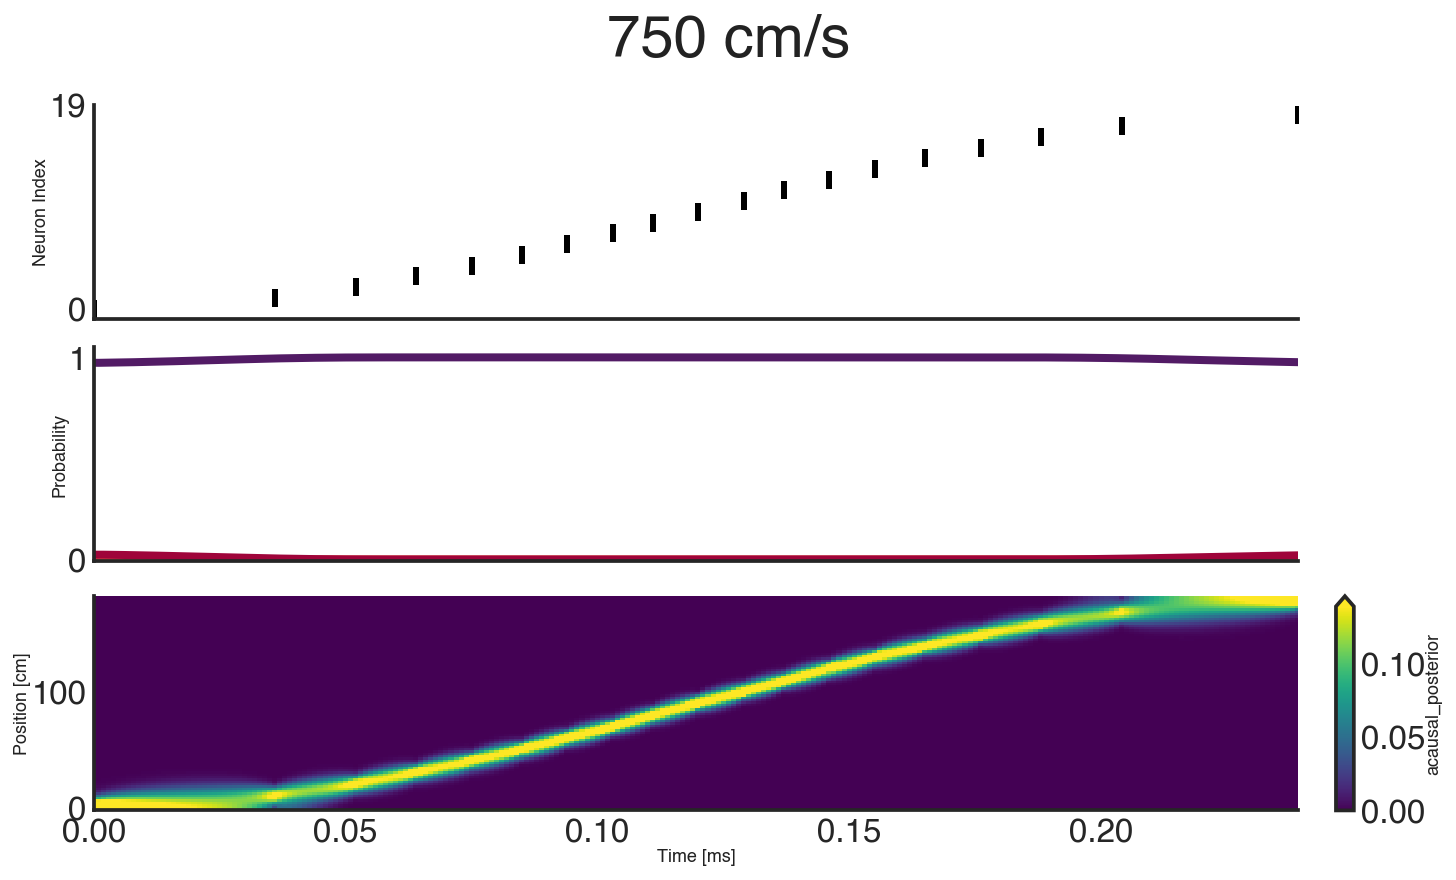

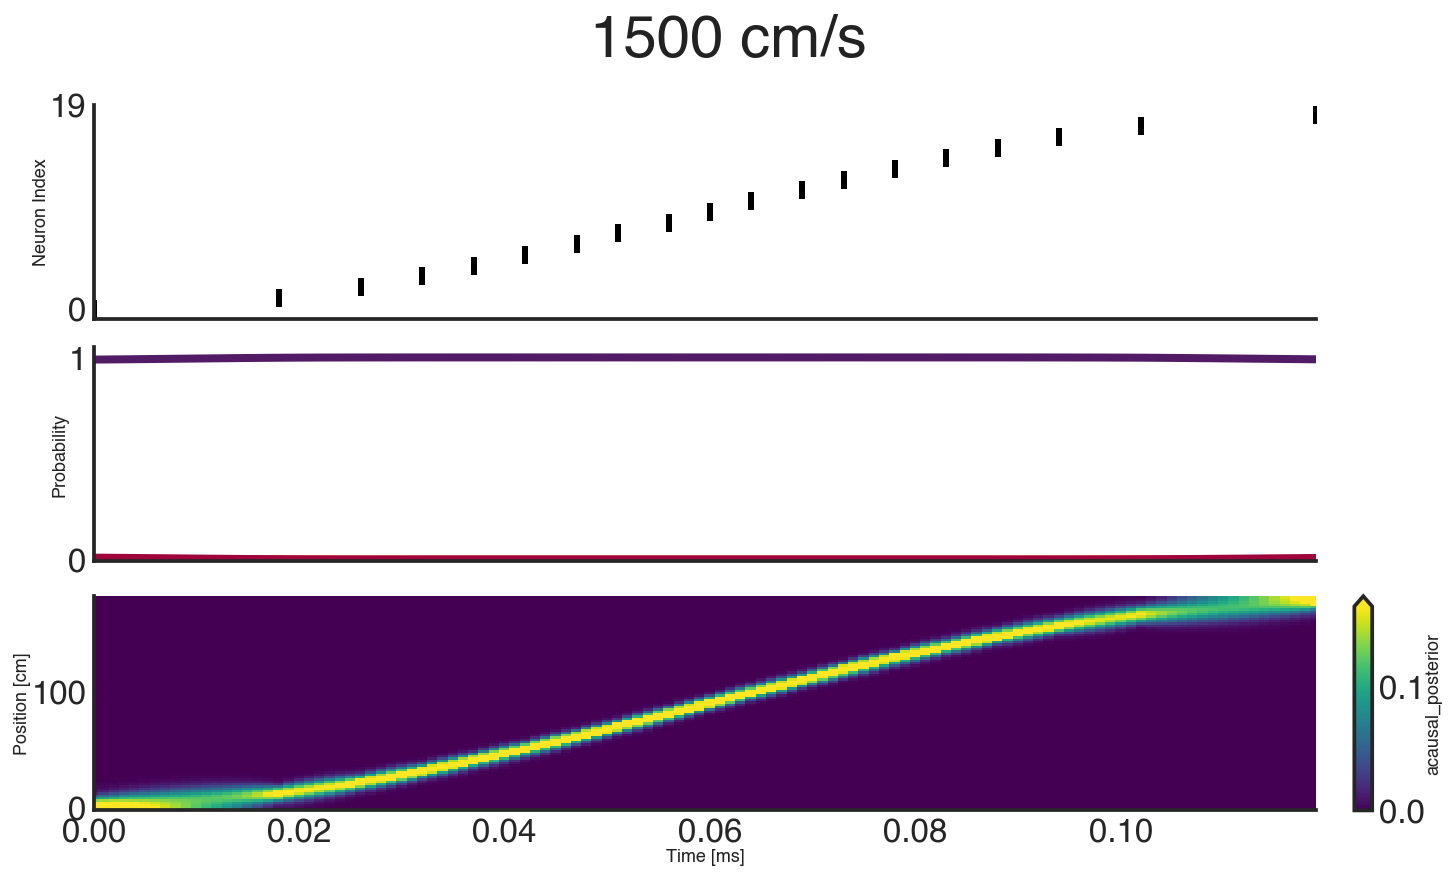

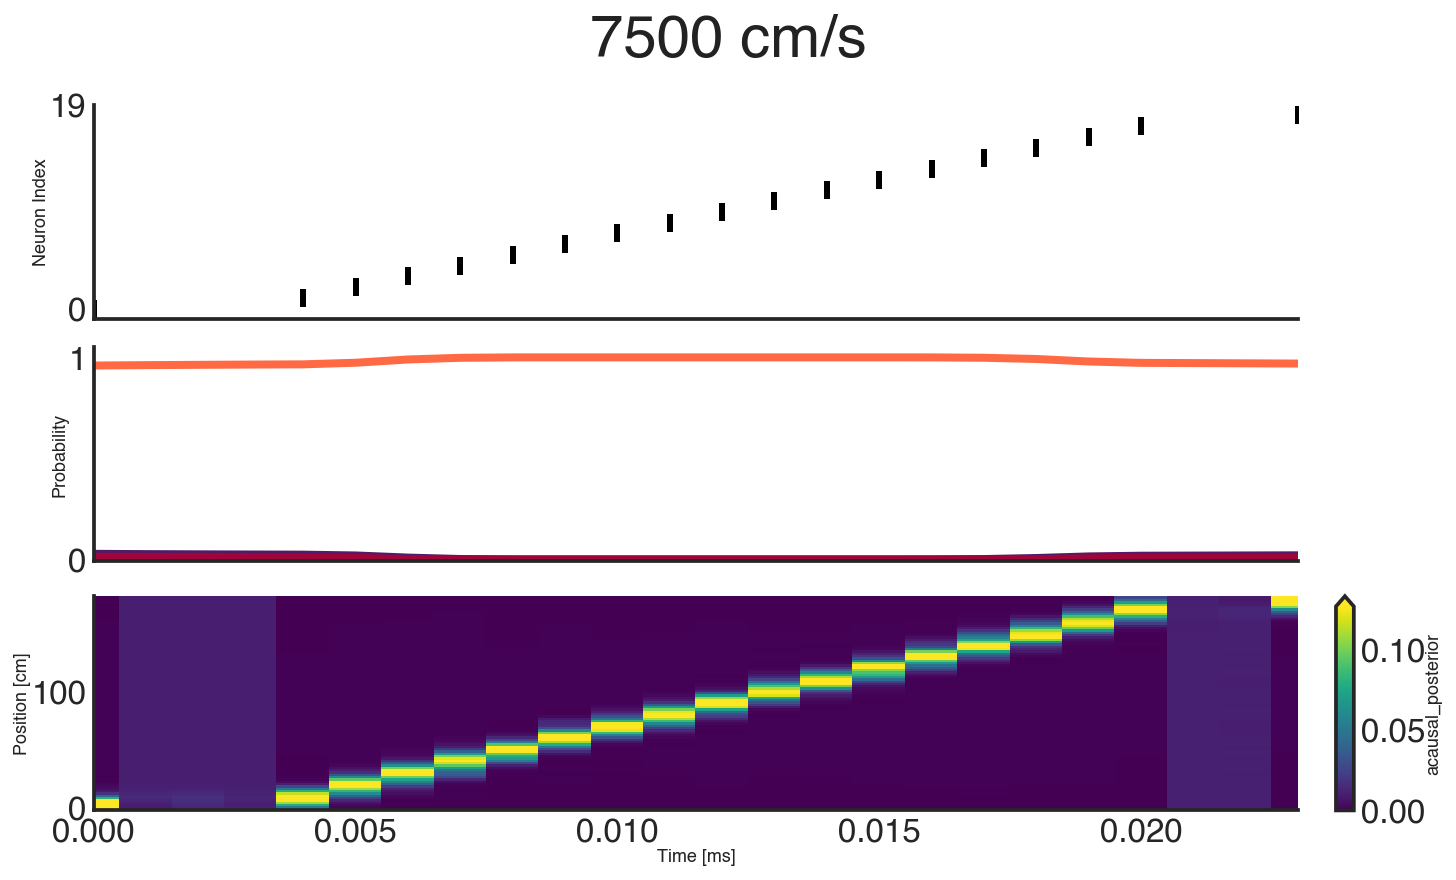

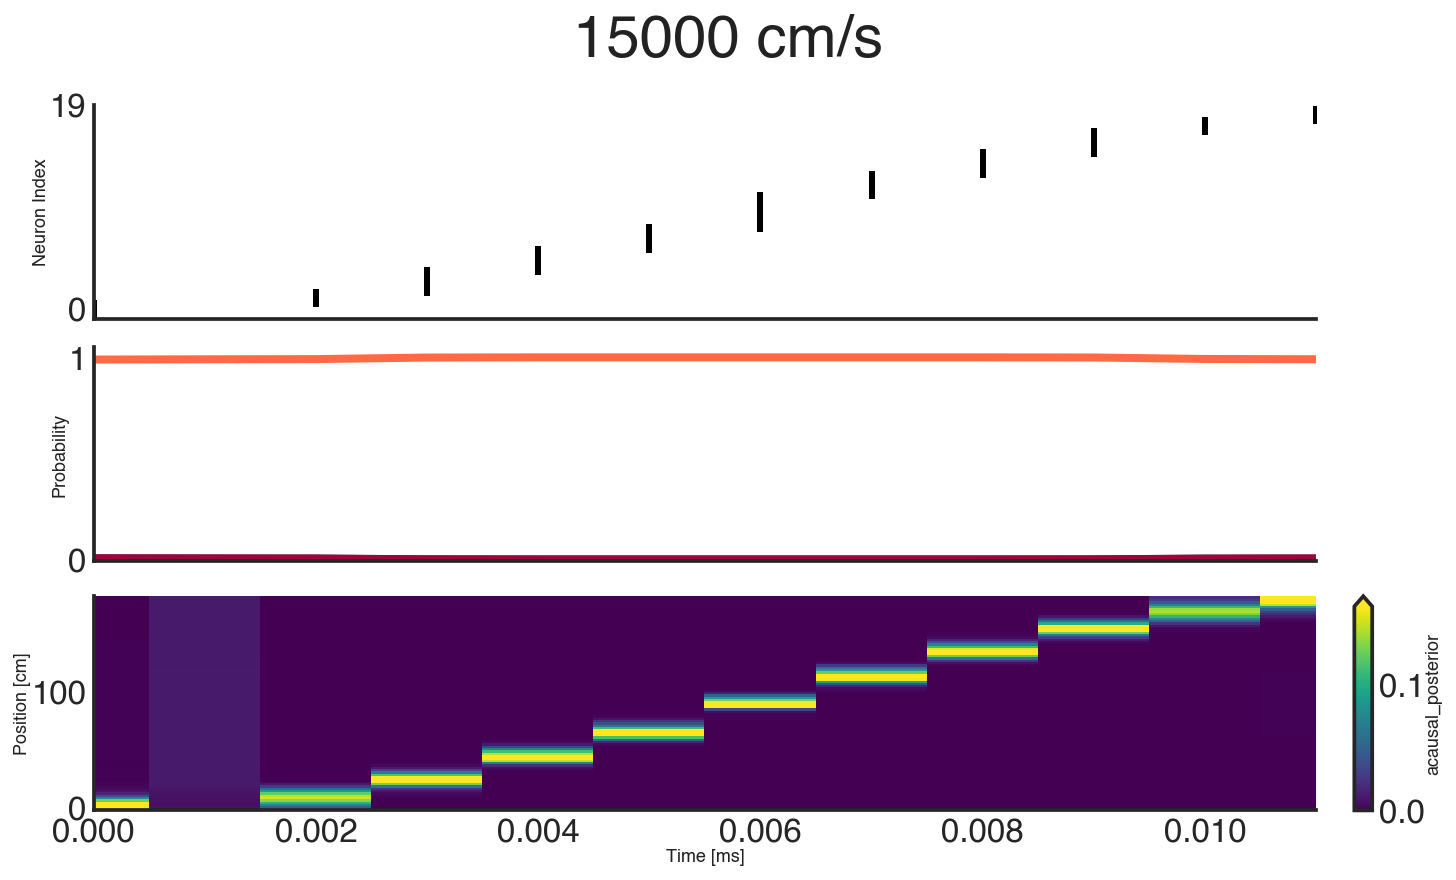

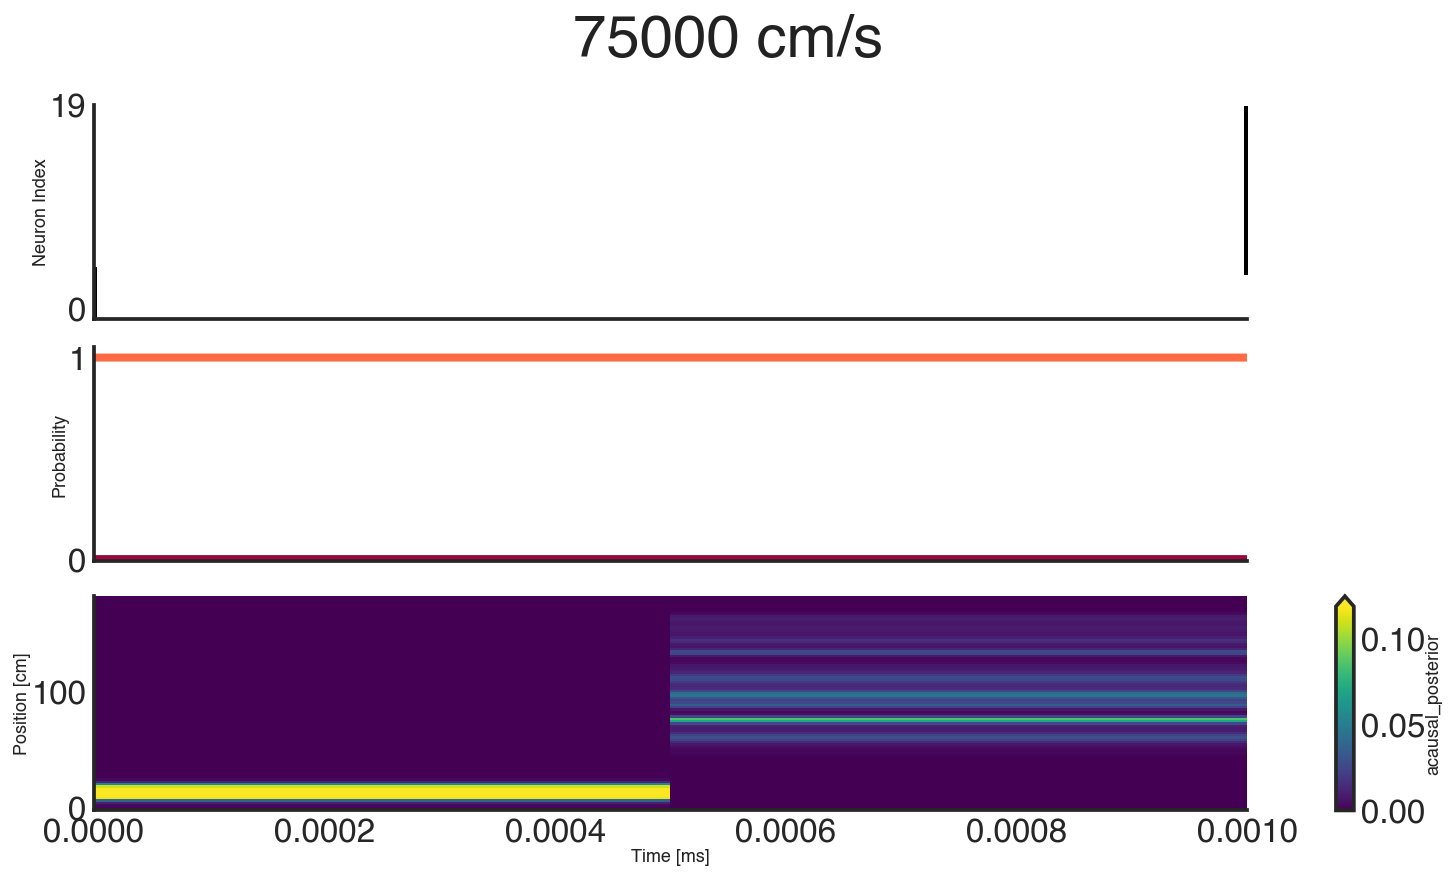

In [6]:
from src.sorted_spikes_simulation import (
    make_continuous_replay, SAMPLING_FREQUENCY, TRACK_HEIGHT, RUNNING_SPEED, PLACE_FIELD_MEANS)

from tqdm.auto import tqdm

for replay_speedup in tqdm([1/15, 1, 5, 10, 50, 100, 500, 1000]):

    replay_time, test_spikes = make_continuous_replay(sampling_frequency=SAMPLING_FREQUENCY,
                               track_height=TRACK_HEIGHT,
                               running_speed=RUNNING_SPEED,
                               place_field_means=PLACE_FIELD_MEANS,
                               replay_speedup=replay_speedup)

    results = classifier.predict(test_spikes, time=replay_time)
    plot_classification(replay_time, test_spikes, results)
    plt.suptitle(f'{RUNNING_SPEED * replay_speedup} cm/s', fontsize=30)


In [ ]:

plt.plot()